# Fitting Notebook
Here we fit the phi-distributions from the analysis notebook.
- Model selection - Cross validation score is used to demonstrate that fitting with the simple model is probably best.
- Fits of $\phi$ - Two methods of fitting the phi distributions are used, one single fit, and the bootstrap replica technique.
- MC study of fitting procedure - This has to wait, but I am going to use MC to throw a distribution in phi that follows the error bars of our measurement.
- Visualization
    - fit phi distributions 
    - bootstrap histograms
    - bootstrap score histograms
    - integrated fit results with errors

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib inline

plt.rc('font', family='serif')
plt.rc('font', size=18)

In [4]:
data = pd.read_csv('results/phi-dist.csv')

In [5]:
data.columns

Index([u'axis', u'axis_bin', u'axis_max', u'axis_min', u'counts_neg',
       u'counts_pos', u'phi', u'phi_bin', u'stat', u'sys_0', u'value',
       u'global_index', u'sys_1', u'sys_10', u'sys_11', u'sys_2', u'sys_3',
       u'sys_4', u'sys_5', u'sys_6', u'sys_7', u'sys_8', u'sys_9',
       u'sys_total'],
      dtype='object')

In [6]:
data.head()

,axis,axis_bin,axis_max,axis_min,counts_neg,counts_pos,phi,phi_bin,stat,sys_0,...,sys_11,sys_2,sys_3,sys_4,sys_5,sys_6,sys_7,sys_8,sys_9,sys_total
0,x,0,0.150192,0.106729,16436,16311,-165.0,0,0.005526,0.000153,...,0.012388,0.000382,0.006687,0.003003,0.000823,0.001769,0.004440,0.001737,0.001579,0.016184
1,x,0,0.150192,0.106729,5994,5694,-135.0,1,0.009244,0.001028,...,0.036935,0.000559,0.007469,0.002108,0.006159,0.004268,0.007956,0.001319,0.008234,0.046834
2,x,0,0.150192,0.106729,12239,11837,-105.0,2,0.006443,0.000669,...,0.009165,0.000639,0.009500,0.010151,0.000039,0.008598,0.003775,0.002740,0.002257,0.025650
3,x,0,0.150192,0.106729,5800,5776,-75.0,3,0.009294,0.000083,...,0.007065,0.000468,0.008975,0.007215,0.001219,0.006447,0.010675,0.004319,0.003017,0.024239
4,x,0,0.150192,0.106729,4752,4481,-45.0,4,0.010399,0.001176,...,0.014624,0.000750,0.011015,0.005194,0.002070,0.005907,0.010280,0.001377,0.008271,0.024337


In [7]:
def chi2(y_true, y_pred, y_err):
    return np.sum((y_true-y_pred)**2/y_err**2)

In [8]:
class Model(object):

    def __init__(self):
        self.n_pars = 1
        self.pars   = np.zeros(shape=(self.n_pars, 1))
        self.bounds = np.array([[-1, 1],], dtype=np.float32)
        
    def get_initial_parameters(self):
        self.pars = np.random.uniform(-1.0, 1.0, size=(self.n_pars, 1))

    def evaluate(self, x):
        return 1.0

class SineModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 1
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 )

class FullModel(Model):

    def __init__(self):
        Model.__init__(self)
        self.n_pars = 3
        self.pars = np.zeros(shape=(self.n_pars, 1), dtype=np.float32)
        self.bounds = np.array([[-1,1],
                                [-1,1],
                                [-1,1]],dtype=np.float32)
    def evaluate(self, x):
        return self.pars[0]*np.sin( x*np.pi/180.0 ) / (1 + self.pars[1]*np.cos(x*np.pi/180.0) + self.pars[2]*np.cos(2*x*np.pi/180.0))

def update_model(model, pars, x):
    model.pars = pars
    return model.evaluate(x)

In [9]:
from scipy.optimize import minimize

In [10]:
model = FullModel()
model.get_initial_parameters()

In [11]:
test_data = data.query('axis == "z" and axis_bin == 2')

In [12]:
test_data

,axis,axis_bin,axis_max,axis_min,counts_neg,counts_pos,phi,phi_bin,stat,sys_0,...,sys_11,sys_2,sys_3,sys_4,sys_5,sys_6,sys_7,sys_8,sys_9,sys_total
96,z,2,0.571011,0.514184,17708,17810,-165.0,0,0.005306,0.000115,...,0.009167,0.000768,0.005322,0.002135,0.000315,0.004526,0.007335,0.002025,0.001209,0.014957
97,z,2,0.571011,0.514184,8581,8384,-135.0,1,0.007677,0.000465,...,0.006443,0.001482,0.002218,0.006442,0.000776,0.009910,0.001650,0.001492,0.003092,0.014355
98,z,2,0.571011,0.514184,10913,10471,-105.0,2,0.006836,0.000828,...,0.001785,0.004938,0.001142,0.004960,0.000099,0.002183,0.000284,0.001238,0.007271,0.016668
99,z,2,0.571011,0.514184,8514,8183,-75.0,3,0.007736,0.000794,...,0.002600,0.003359,0.002712,0.002760,0.000230,0.007114,0.006405,0.002123,0.004510,0.016133
100,z,2,0.571011,0.514184,4391,4144,-45.0,4,0.010816,0.001159,...,0.008904,0.003290,0.007851,0.006677,0.001923,0.009447,0.004084,0.002524,0.005561,0.021236
101,z,2,0.571011,0.514184,1693,1604,-15.0,5,0.017404,0.001081,...,0.016251,0.005638,0.013812,0.016507,0.003297,0.016742,0.006336,0.006371,0.020773,0.041360
102,z,2,0.571011,0.514184,1630,1619,15.0,6,0.017544,0.000136,...,0.023111,0.007916,0.015051,0.006687,0.003104,0.020578,0.033875,0.012754,0.006947,0.053236
103,z,2,0.571011,0.514184,4298,4288,45.0,7,0.010792,0.000047,...,0.009828,0.004312,0.009414,0.005216,0.003389,0.004035,0.002663,0.001242,0.003191,0.023723
104,z,2,0.571011,0.514184,8100,8340,75.0,8,0.007798,0.000585,...,0.003861,0.003732,0.001199,0.003802,0.000094,0.004396,0.001031,0.001239,0.006674,0.016071
105,z,2,0.571011,0.514184,10301,10987,105.0,9,0.006847,0.001291,...,0.005616,0.002102,0.002549,0.005933,0.000225,0.015431,0.011103,0.000428,0.001775,0.021499


In [13]:
from sklearn.utils import shuffle

def setup_dataframe(n_folds, x, y, y_err, shuf=False):
    
    if len(y) % n_folds != 0:
        print('Data (%d) is not divisible into %d folds.' % (len(y), n_folds))
        return 
    
    x = x.transpose()
    y = y.transpose()
    y_err = y_err.transpose()
    
    d  = {'x':x, 'y':y, 'y_err':y_err}
    df = pd.DataFrame(data=d)
    
    if shuf is True:
        df = shuffle(df)

    chunk_size = int(len(y)/n_folds) 
    
    a = np.arange(0,n_folds)
    df['chunk'] = np.repeat(a,chunk_size)
    return df

def cross_validate(n_folds, model, df):

    validation_scores = []
    parameters = []
    for i in range(n_folds):
        res = minimize(fun=lambda p: np.average((df.query('chunk != %d' % i).y - update_model(model, p, df.query('chunk != %d' % i).x))**2/df.query('chunk != %d' % i).y_err**2), 
                    x0=model.pars, bounds=model.bounds)
                                
        y_pred = update_model(model, res.x, df.query('chunk == %d' % i).x)
        validation_scores.append(np.average((df.query('chunk == %d' % i).y-y_pred)**2/df.query('chunk == %d' % i).y_err**2))
        parameters.append(res.x)
        
    return np.array(validation_scores), parameters

In [14]:
models = {}

models['basic'] = SineModel()
models['full'] = FullModel()
models['half'] = FullModel()
models['half'].bounds = np.array([[-1,1],[-1,1],[-0.0001,0.0001]], dtype=np.float32)

models['full_bounded'] = FullModel()
models['full_bounded'].bounds = np.array([[-1,1],[-0.1,0.1],[-0.1,0.1]], dtype=np.float32)
                                          
for m in models.values():
    m.get_initial_parameters()

In [15]:
CHUNKS = 3
df_chunked = setup_dataframe(CHUNKS, test_data.phi, test_data.value, np.sqrt(test_data.sys_total**2 + test_data.stat**2), shuf=False)

In [16]:
cv_scores = {}
cv_pars = {}

for name, m in models.iteritems():
    print('Fitting %s' % name)
    cv_scores[name], cv_pars[name] = cross_validate(CHUNKS, m, df_chunked)

Fitting full_bounded
Fitting half
Fitting full
Fitting basic


In [17]:
cv_scores

{'basic': array([0.14987263, 0.44172182, 0.24500725]),
 'full': array([0.20438279, 0.57750681, 0.32250448]),
 'full_bounded': array([0.20299266, 0.45877579, 0.2691167 ]),
 'half': array([0.20031037, 0.43944854, 0.30827155])}

In [18]:
cv_pars

{'basic': [array([0.02877498]), array([0.02655725]), array([0.02602331])],
 'full': [array([ 0.02910357,  0.12079648, -0.02865078]),
  array([0.01580644, 0.39035146, 0.50853672]),
  array([ 0.02375766, -0.2578714 ,  0.156954  ])],
 'full_bounded': [array([ 0.02936268,  0.1       , -0.04744814]),
  array([0.02471874, 0.07506848, 0.1       ]),
  array([ 0.02490738, -0.1       ,  0.1       ])],
 'half': [array([ 2.87244981e-02,  1.37887776e-01, -9.99999975e-05]),
  array([ 2.66896625e-02, -2.87568419e-02,  9.99999975e-05]),
  array([ 2.58334132e-02, -2.80538125e-01,  9.99999975e-05])]}

In [19]:
for k,v in cv_scores.iteritems():
    print(k, np.average(v))

('basic', 0.2788672299020621)
('full_bounded', 0.31029505124259016)
('full', 0.3681313580745629)
('half', 0.3160101545357566)


<Container object of 4 artists>

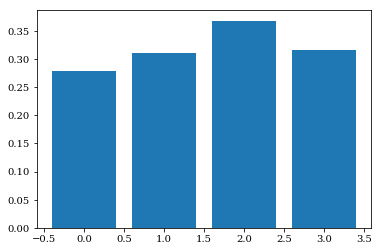

In [20]:
h = [np.average(xx) for xx in cv_scores.values()]
plt.bar(np.arange(len(cv_scores.keys())), height=h)

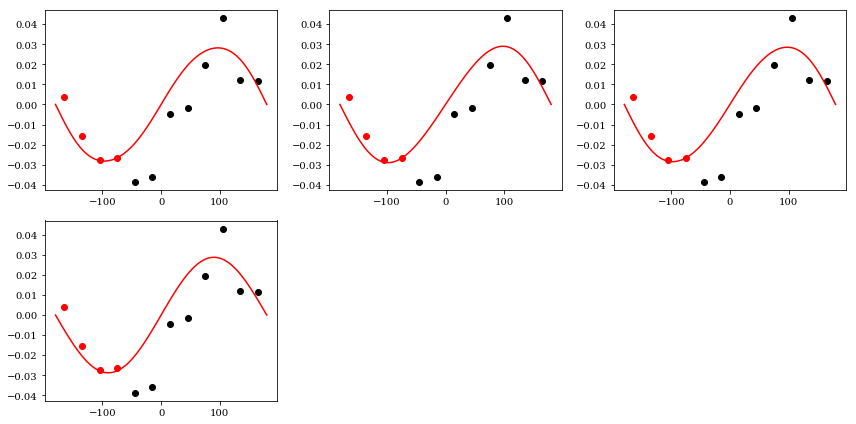

In [21]:
n_col = 3
n_row = np.ceil((len(cv_pars.keys())-1)/n_col)+1
plt.figure(figsize=(n_col*4, n_row*3))

train = df_chunked.query('chunk != 0')
test  = df_chunked.query('chunk == 0')

index = 1
x = np.linspace(-180,180,100)
for name, model in models.iteritems():
    plt.subplot(n_row, n_col, index)
    plt.plot(train.x, train.y, linestyle='', marker='o', color='black')
    plt.plot(test.x, test.y, linestyle='', marker='o', color='red')
    
    y = [update_model(model, cv_pars[name][0], xi) for xi in x]
    plt.plot(x, y, color='red')
    index += 1
    
plt.tight_layout()

In [22]:
def generate_toy_data(df, model):
    d = df.copy(deep=True)
    d.value = model.evaluate(d.phi) + np.random.normal(loc=0.0, scale=d.stat)
    return d

In [23]:
#models['full'].pars = [0.05, 0.02, -0.02]
models['basic'].pars = [0.065]
mc = generate_toy_data(test_data, models['basic'])

<Container object of 3 artists>

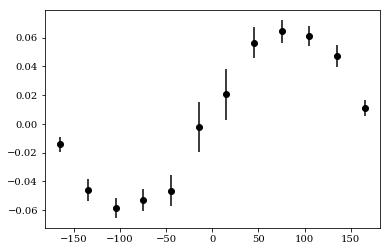

In [24]:
plt.errorbar(x=mc.phi, y=mc.value, yerr=mc.stat, color='black', 
            linestyle='', marker='o')

In [25]:
rmc = minimize(fun=lambda x: chi2(mc.value, update_model(models['full'], x, mc.phi), np.sqrt(mc.stat**2 + mc.sys_total**2)), 
             x0=models['full'].pars,
            bounds=models['full'].bounds)

In [26]:
rmc

      fun: 0.7508921801991574
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.86222157e-03, -1.78412840e-05, -1.66866521e-04])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 100
      nit: 17
   status: 0
  success: True
        x: array([ 0.06349379, -0.0636333 , -0.02658791])

In [27]:
def single_fit(model, data):
    model.get_initial_parameters()
    res = minimize(fun=lambda x: chi2(data.value, update_model(model, x, data.phi), np.sqrt(data.stat**2 + data.sys_total**2)), 
             x0=model.pars, bounds=model.bounds)

    identity = np.identity(len(model.pars))
    err = np.sqrt(np.array(np.matrix(res.hess_inv * identity).diagonal()))
    #err.reshape(model.n_pars,1)
    
    return res.x, err

In [28]:
def create_replica(y, y_err):
    y_rep = [np.random.normal(yp, np.fabs(yp_err)) for yp, yp_err in zip(y,y_err)]
    return np.array(y_rep)

In [29]:
def bootstrap_fit(model, data, n_replicas=100):

    results = []
    scores = []
    
    for irep in range(n_replicas):
        d = data.copy(deep=True)
        rep = create_replica(d.value, np.sqrt(d.stat**2 + d.sys_total**2)) 
        d['value'] = rep   
        pars,errs = single_fit(model, d)
        results.append(pars)
        scores.append(chi2(d.value, update_model(model, pars, d.phi), np.sqrt(d.stat**2 + d.sys_total**2)))
        
        if irep%10 is 0:
            print('Processing replica (%d/%d)' % (irep, n_replicas))
            
    return np.array(results), np.array(scores)

In [30]:
boot,boot_score = bootstrap_fit(models['half'], test_data, 500)

Processing replica (0/500)
Processing replica (10/500)
Processing replica (20/500)
Processing replica (30/500)
Processing replica (40/500)
Processing replica (50/500)
Processing replica (60/500)
Processing replica (70/500)
Processing replica (80/500)
Processing replica (90/500)
Processing replica (100/500)
Processing replica (110/500)
Processing replica (120/500)
Processing replica (130/500)
Processing replica (140/500)
Processing replica (150/500)
Processing replica (160/500)
Processing replica (170/500)
Processing replica (180/500)
Processing replica (190/500)
Processing replica (200/500)
Processing replica (210/500)
Processing replica (220/500)
Processing replica (230/500)
Processing replica (240/500)
Processing replica (250/500)
Processing replica (260/500)
Processing replica (270/500)
Processing replica (280/500)
Processing replica (290/500)
Processing replica (300/500)
Processing replica (310/500)
Processing replica (320/500)
Processing replica (330/500)
Processing replica (340/5

In [31]:
boot[:,0]

array([0.01485498, 0.03356485, 0.00941921, 0.02185848, 0.02963153,
       0.02833993, 0.02918124, 0.02778329, 0.02720153, 0.02077428,
       0.01240771, 0.02994984, 0.02178225, 0.03380359, 0.02345375,
       0.03940173, 0.02982324, 0.02907142, 0.00538852, 0.03763456,
       0.04012936, 0.02287545, 0.02464353, 0.01479236, 0.01515186,
       0.02442826, 0.03014034, 0.03226507, 0.02115857, 0.01647076,
       0.02413808, 0.02777815, 0.03073843, 0.02375889, 0.03378275,
       0.03325718, 0.03772684, 0.02620093, 0.01586915, 0.01196762,
       0.0186912 , 0.01427094, 0.028161  , 0.01323119, 0.02277408,
       0.02538584, 0.02309623, 0.02163997, 0.02548201, 0.01831581,
       0.02473332, 0.03461574, 0.03033729, 0.03550933, 0.03285831,
       0.01488918, 0.02792674, 0.04496942, 0.03058383, 0.03500478,
       0.01074459, 0.03102804, 0.0382986 , 0.01470488, 0.02364532,
       0.00776826, 0.01673362, 0.03467227, 0.01672984, 0.01678783,
       0.03077011, 0.01953479, 0.026028  , 0.02354645, 0.02759

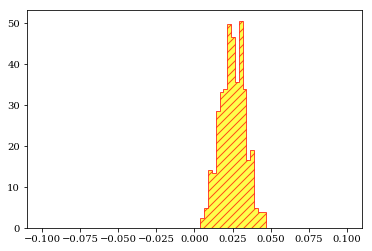

In [32]:
hb = np.linspace(-0.1, 0.1, 80)
plt.hist(boot[:,0], bins=hb, normed=True, histtype='stepfilled',
        color='yellow', edgecolor='red', alpha=0.7, hatch='///');
#plt.hist(boot[:,1], bins=hb);
#plt.hist(boot[:,2], bins=hb);

In [33]:
np.average(boot[:,0]), np.std(boot[:,0])

(0.024957036966403084, 0.008050087479312271)

In [34]:
np.average(boot[:,1]), np.std(boot[:,1])

(-0.11547829063107751, 0.517380312675719)

In [35]:
def fit_dataset(data, model, fit_type='single'):
    '''
    inputs
    ------
    
    data: a dataframe which contains the output of the analysis notebook, phi-distributions 
    
    model: a model object
    
    '''
    
    result = {}
    result['axis'] = []
    result['axis_bin'] = []
    
    for p in range(model.n_pars):
        result['par_%d' % p] = []
        result['err_%d' % p] = []
        
    for axis in np.unique(data.axis):
        dsub = data.query('axis == "%s"' % axis)
        
        for bin in np.unique(dsub.axis_bin):
            d = dsub.query('axis_bin == %d' % bin)
            
            # get fit to data
            #pars,errs = single_fit(model, dsub)
            boot, boots = bootstrap_fit(model, d, n_replicas=80)
            
            pars = []
            errs = []
            for ipar in range(model.n_pars):
                pars.append(np.average(boot[:,ipar]))
                errs.append(np.std(boot[:,ipar]))
            
            result['axis'].append(axis)
            result['axis_bin'].append(bin)
            
            for p in range(model.n_pars):
                result['par_%d' % p].append(pars[p])
                result['err_%d' % p].append(errs[p])
            
    return pd.DataFrame(result)

In [36]:
fitres = fit_dataset(data, models['basic'])

Processing replica (0/80)
Processing replica (10/80)
Processing replica (20/80)
Processing replica (30/80)
Processing replica (40/80)
Processing replica (50/80)
Processing replica (60/80)
Processing replica (70/80)
Processing replica (0/80)
Processing replica (10/80)
Processing replica (20/80)
Processing replica (30/80)
Processing replica (40/80)
Processing replica (50/80)
Processing replica (60/80)
Processing replica (70/80)
Processing replica (0/80)
Processing replica (10/80)
Processing replica (20/80)
Processing replica (30/80)
Processing replica (40/80)
Processing replica (50/80)
Processing replica (60/80)
Processing replica (70/80)
Processing replica (0/80)
Processing replica (10/80)
Processing replica (20/80)
Processing replica (30/80)
Processing replica (40/80)
Processing replica (50/80)
Processing replica (60/80)
Processing replica (70/80)
Processing replica (0/80)
Processing replica (10/80)
Processing replica (20/80)
Processing replica (30/80)
Processing replica (40/80)
Proces

In [37]:
fitres

,axis,axis_bin,err_0,par_0
0,pt,0,0.008655,0.026354
1,pt,1,0.007899,0.037494
2,pt,2,0.008183,0.030251
3,pt,3,0.008588,0.038885
4,pt,4,0.005892,0.026736
5,pt,5,0.006921,0.022669
6,q2,0,0.010160,0.016986
7,q2,1,0.008014,0.037416
8,q2,2,0.006307,0.035814
9,q2,3,0.006774,0.033587


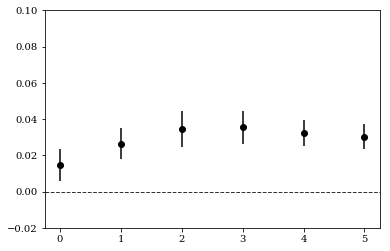

In [38]:
plt.errorbar(x=fitres.query('axis == "x"').axis_bin, 
             y=fitres.query('axis == "x"').par_0, 
             yerr=fitres.query('axis == "x"').err_0,
            linestyle='', marker='o', color='black')

plt.ylim([-0.02, 0.1])
plt.axhline(0.0, linestyle='--', color='black', alpha=0.8, linewidth=1)

Text(0.5,0,u'chi-2')

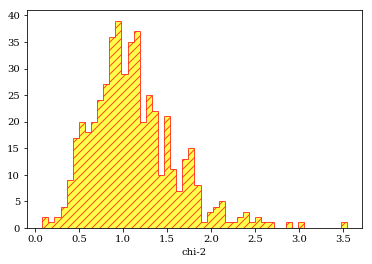

In [39]:
plt.hist(boot_score/12.0, bins=50, histtype='stepfilled',
        color='yellow', edgecolor='red', hatch='///', alpha=0.7);
plt.xlabel('chi-2')

In [40]:
def plot_results(results, axis):
    
    d      = results.query('axis == "%s"' % axis)
    n_bins = len(np.unique(d.axis_bin))
    n_col  = 3
    n_row  = np.ceil(n_bins/n_col)+1

    # these are uniform width
    phi_width = np.repeat(float(360.0/len(np.unique(d.phi_bin))), len(np.unique(d.phi_bin)))
    phi_edges = np.linspace(-180,180,len(np.unique(d.phi_bin)))
    plt.figure(figsize=(4*n_col, 3*n_row))
    
    for index in range(n_bins):
        dsub = d.query('axis_bin == %d' % index)
        plt.subplot(n_row, n_col, index+1)
        plt.errorbar(x=dsub.phi, y=dsub.value, yerr=dsub.stat, 
                    linestyle='', marker='o', color='black')
        
        if 'sys_total' in dsub.columns:
            plt.bar(phi_edges, height=dsub.sys_total, width=phi_width, bottom=0.0, 
                    edgecolor='green', color='yellow', alpha=0.65, hatch='///', 
                    label='systematic error', align='edge')
            
        plt.axhline(0.0, linestyle='--',
                    linewidth=1, color='black', alpha=0.4)
        
        plt.xlim([-180,180])
        plt.ylim([-0.15, 0.15])
        
    plt.tight_layout()

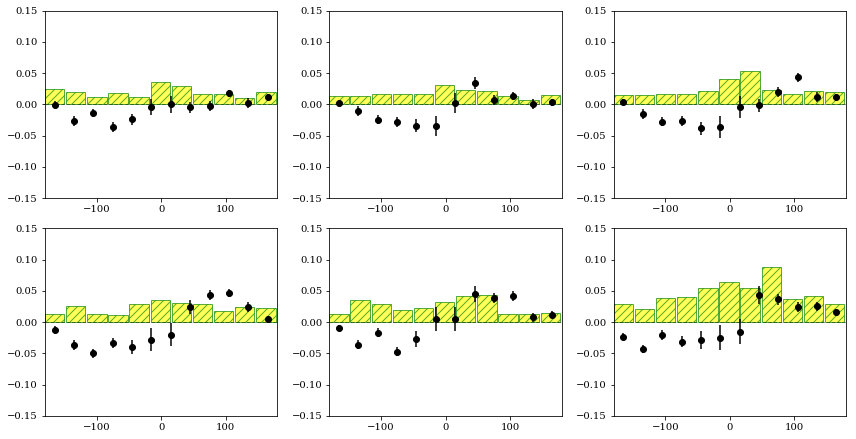

In [41]:
plot_results(data, axis='z')